In [7]:
import pandas as pd
import sqlalchemy
import math
import os, sys, copy, random, pickle, cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

sys.path.append("../")

%load_ext autoreload
%autoreload 2

from modules.ControlTracking import TrackFactory
from modules.ControlDisplay import Display
from modules.Interproc import DBInterface, GuiviewState

from modules.AnalysisHelpers import ( 
         exploreImgs, buildImgComparisonData, subprocEval)

from modules.EvalHelpers import EvalTracker, EvalDataset
from modules.ControlEval import EvalFactory
from modules.DataSchemas import ScoreSchema
from modules.EvalHelpers import OutcomeData

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Display basic summaries from OutcomeData

In [256]:
from modules.EvalHelpers import OutcomeData
od = OutcomeData()

In [257]:
od.displaySummaryStats()

num frames:                  383
obj enums scored/tracked:    0,1 / 0
num scored frames:           10 | 0,22,40...125,188,380
-------


In [258]:
od.displayCondensedTable()[:4]

,input_data0_0,input_data1_0,input_data2_0,input_data3_0,input_obj_exists_0,input_obj_type_0,track_data0_0,track_data1_0,track_data2_0,track_data3_0,track_obj_exists_0,track_obj_type_0
0,436.0,320.0,68.0,68.0,True,circle,445.0,332.0,54.0,54.0,True,circle
22,152.0,240.0,92.0,96.0,True,circle,147.0,241.0,99.0,99.0,True,circle
40,528.0,208.0,94.0,94.0,True,circle,535.0,219.0,98.0,98.0,True,circle
47,1018.0,182.0,92.0,100.0,True,circle,NaN,NaN,NaN,NaN,None,None


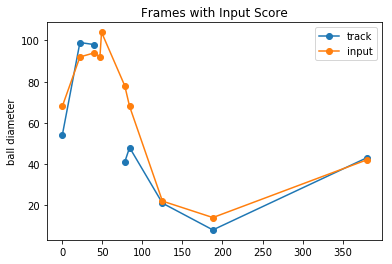

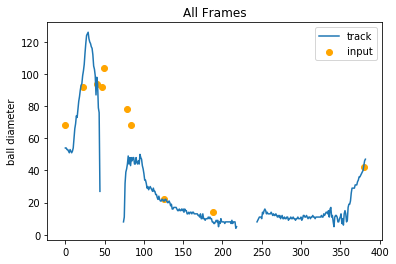

In [259]:
od.displayDiameterPlot()

### DiameterPlotData => sorted => FramesOfInterest

In [264]:
data = od.displayDiameterPlot(b_ret=True)

In [300]:
# use return data to find frames-of-interest:
#   where's the largest discrepancy?

replace_nan = 0  #0=ignore nan's, 999=highlight nan's

ipt, trk = data[False]['input'], data[False]['track']

ipt_y, trk_y, x = ipt[1], trk[1], ipt[0]

tracker_diff = [(x, trk - ipt) for ipt, trk, x in zip(ipt_y, trk_y, x)]

tracker_diff = map(lambda elem: (elem[0],
                         replace_nan if math.isnan(elem[1]) else elem[1]
                                )
                   ,tracker_diff)

tracker_diff.sort(key=lambda elem: abs(elem[1]), reverse=True)
print tracker_diff

num_frames = 3
foiList = [elem[0] for elem in tracker_diff[:num_frames]]
print 'FOI at these frame counters: ', str(foiList)

[(78, -37.0), (84, -20.0), (0, -14.0), (22, 7.0), (188, -6.0), (40, 4.0), (125, -1.0), (380, 1.0), (47, 0), (49, 0)]
FOI at these frame counters:  [78, 84, 0]


### Multi-Vid Comparison Plots

data/proc/tmp/dec14/output5.proc1.avi
num frames:                  345
obj enums scored/tracked:    0,1 / 0
num scored frames:           10 | 0,9,78...246,307,340
-------


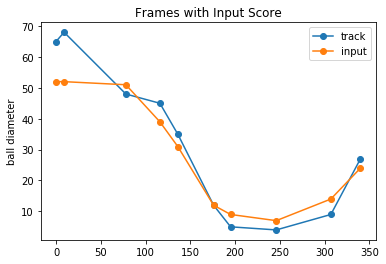

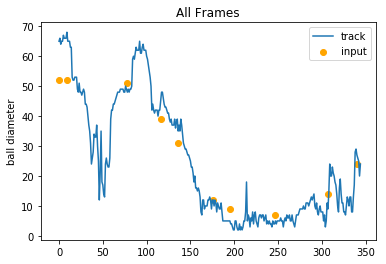

data/proc/tmp/dec14/output6.proc1.avi
num frames:                  383
obj enums scored/tracked:    0,1 / 0
num scored frames:           10 | 0,22,40...125,188,380
-------


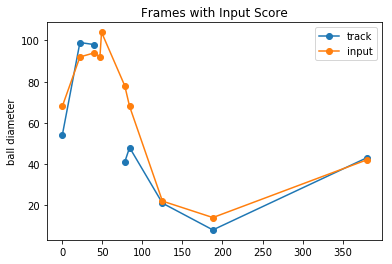

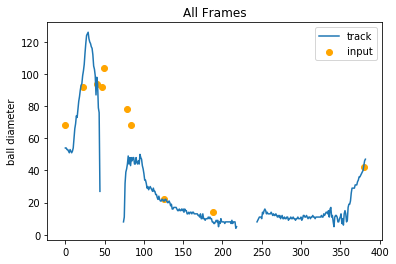

In [301]:
vids = [
     'data/proc/tmp/dec14/output5.proc1.avi'
    ,'data/proc/tmp/dec14/output6.proc1.avi'
]

od_dict = {}

for vid_fn in vids:
    _ = subprocEval(vid_fn)
    _od = OutcomeData()
    od_dict[vid_fn] = copy.deepcopy(_od)

for _k in od_dict.keys():
    print _k
    _odObj = od_dict[_k]
    _odObj.displaySummaryStats()
    _odObj.displayDiameterPlot()